# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Задачи проекта:**
- построить модель для определения стоимости автомобиля

**Данные - файл, содержащий следующие сведения:**
* Признаки
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - NotRepaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
* Целевой признак
    - Price — цена (евро)

**План работы**:
- Загрузка и подготовка данных 
- Построение моделей
- Оценка качества полученных моделей
    - расчет RMSE (среднеквадратическая ошибка)
    - расчет времени выполнения кода

## Подготовка данных

In [1]:
#!pip install -qq catboost

In [2]:
#! pip install lightgbm

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, cv, Pool
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

### загрузка и ознакомление

In [5]:
df_start = pd.read_csv('/datasets/autos.csv')

In [6]:
df_start.info()
display(df_start.head())
print('Количество признаков:', df_start.shape[1], ', количество наблюдений:', df_start.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Количество признаков: 16 , количество наблюдений: 354369


Посмотрим пропуски:

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

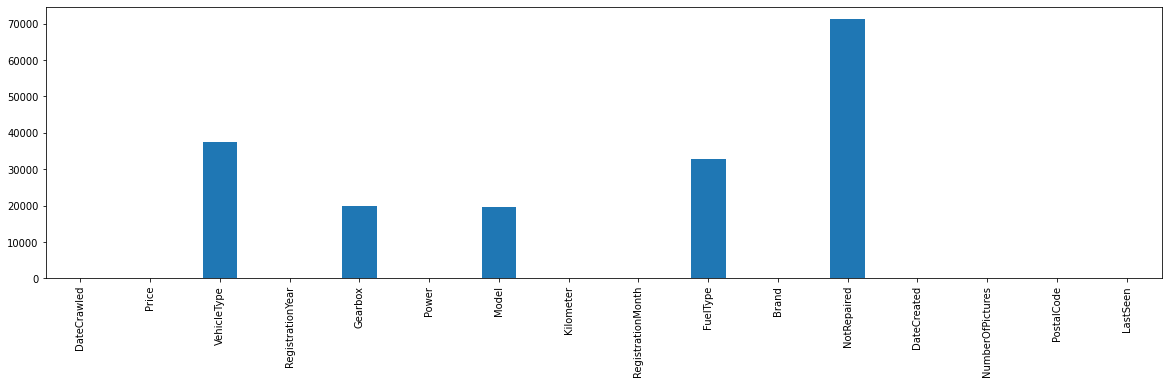

In [7]:
df_start.isna().sum().plot.bar(figsize=(20,5))
df_start.isna().sum()

In [8]:
print('Количество дубликатов:', df_start.duplicated().sum())

Количество дубликатов: 4


### Удаление дубликатов и несущественных признаков

Можно сразу удалить столбцы, не относящиеся к ценообразующим (количество фото, дата создания анкеты, дата последней активности пользователя)

In [9]:
data_avto = df_start.drop(['NumberOfPictures', 'LastSeen', 'DateCreated', 'RegistrationMonth', 'DateCrawled', 'PostalCode'],
                          axis=1)


> Почтовый индекс конечно можно рассматривать как ценообразующий фактор в части деления на регионы. Автомобиль в Москве и на Камчатке может иметь разницу в цене, но для этого необходимо создать классификатор региона по коду индекса. 

In [10]:
df_start = df_start.drop_duplicates().reset_index(drop=True)

In [11]:
data_avto.shape # для проверки

(354369, 10)

### Возраст авто

Один из основных признаков, влияющий на стоимость автомобиля - возраст. Проверим:

In [12]:
data_avto['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [13]:
data_avto.query('RegistrationYear < 1970').count()

Price               1338
VehicleType         1075
RegistrationYear    1338
Gearbox              933
Power               1338
Model                852
Kilometer           1338
FuelType             968
Brand               1338
NotRepaired          798
dtype: int64

- Мы увидели, что в данных имеются как недостоверные сведения, так и сведения об автомобилях с 1900 года. 
- Чаще всего, автомобили старше 50 лет являются раритетными, восстановленными и аукционными. Брать их в расчет не имеет смысла. 
- Удаляем сведения об автомобилях старше 1970 года, а так же содержащие недостоверные сведения. (1338 наблюдения)

In [14]:
data_avto = data_avto.query('RegistrationYear >= 1970').reset_index(drop=True)

In [15]:
data_avto.query('RegistrationYear < 1970').count() #проверяем

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [16]:
data_avto.shape #проверяем

(353031, 10)

### Мощность авто

Мощность автомобиля. Так же одним из главным ценоопределяющих признаков автомобиля является мощность (л/с). Согласно статьям [самые маломощные автомобили](https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html) и [Самые мощные автомобили](https://www.a777aa77.ru/power.php?brand_id=105) широкое распространение получили автомобили от 40 л/с до 1000 л/с.

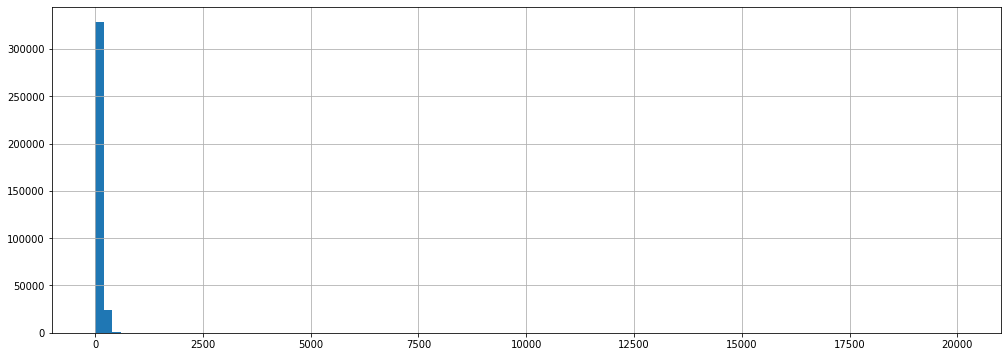

In [17]:
sorted(data_avto['Power'].unique())
data_avto['Power'].hist(bins=100, figsize=(17,6));

In [18]:
data_avto.query('Power > 1000 or Power < 40').count() # авто меньше 40 или больше 1000


Price               41181
VehicleType         26581
RegistrationYear    41181
Gearbox             28102
Power               41181
Model               34837
Kilometer           41181
FuelType            29592
Brand               41181
NotRepaired         19701
dtype: int64

In [19]:
data_avto.query('Power == 0').count() # авто с мощностью 0

Price               39657
VehicleType         25250
RegistrationYear    39657
Gearbox             26700
Power               39657
Model               33619
Kilometer           39657
FuelType            28302
Brand               39657
NotRepaired         18606
dtype: int64

В датафрейме 41181 наблюдениt, где мощность меньше 40 и больше 1000 л/с, в том числе 39657 наблюдений, где мощность 0

Наблюдения, где мощность автомобиля меньше 40 и больше 800 (исправим опечатки) заменим на медиану по бренду и модели

In [20]:
power_transformed = data_avto.groupby(['Brand', 'Model', 'Gearbox'])['Power'].transform('median')
data_avto.loc[(data_avto['Power'] < 40) | (data_avto['Power'] > 600), 'Power'] = power_transformed

In [21]:
data_avto.query('Power > 1000 or Power < 40').pivot_table(index='Power', values='Brand', aggfunc='count')

,Brand
Power,
0.00,15
16.00,5
22.50,3
23.00,1
26.00,267
38.00,2
39.00,13


In [22]:
data_avto['Power'].isna().sum()

16407

Эти данные можно удалить.

In [23]:
data_avto = data_avto.query('40 <= Power <= 1000').reset_index(drop=True)
data_avto.shape

(336318, 10)

### Модель авто, ремонт, коробка передач, вид топлива и тип кузова

**Посмотрим пропуски в признаказ `Model`**

In [24]:
data_avto['Model'].isna().sum()

12863

Заменим на первое вхождение по условию совпадения 'Brand', 'Gearbox', 'FuelType'

In [25]:
model_transformed = data_avto.groupby(['Brand', 'Gearbox', 'FuelType'])['Model'].transform('first')
data_avto['Model'] = data_avto['Model'].fillna(model_transformed)

In [26]:
data_avto['Model'].isna().sum()

5515

Мы восстановили половину пропущенных данных, остальные заменим на `unknown`

In [27]:
data_avto['Model'] = data_avto['Model'].fillna('unknown')

**Заменим пропуски в данных о ремонте `NotRepaired`**

In [28]:
data_avto.pivot_table(index='NotRepaired', values='Brand', aggfunc='count')

,Brand
NotRepaired,
no,242202
yes,34557


Только 34556 объявления содержат сведения о ремонте, заменим пропуски по большенству `no`. Предполагаем, что если ремонт не производился, то и ставить отметку при заполнении объявления небыло необходимости

In [29]:
data_avto['NotRepaired'] = data_avto['NotRepaired'].fillna('no')

**Посмотрим пропуски 'Gearbox'**

In [30]:
data_avto['Gearbox'].isna().sum()

6343

Заменим на первое вхождение по условию совпадения 'Brand', 'Model', 'Power', 'FuelType'

In [31]:
gearbox_transformed = data_avto.groupby(['Brand', 'Model', 'Power', 'FuelType'])['Gearbox'].transform('first')
data_avto['Gearbox'] = data_avto['Gearbox'].fillna(gearbox_transformed)

In [32]:
data_avto['Gearbox'].isna().sum()

2247

In [33]:
data_avto['Gearbox'] = data_avto['Gearbox'].fillna('unknown')

**Посмотрим пропуски 'FuelType'**

In [34]:
data_avto['FuelType'].isna().sum()

24523

Заменим на первое вхождение по условию совпадения 'Brand', 'Model', 'Power', 'Gearbox'

In [35]:
fuel_transformed = data_avto.groupby(['Brand', 'Model', 'Power', 'Gearbox'])['FuelType'].transform('first')
data_avto['FuelType'] = data_avto['FuelType'].fillna(fuel_transformed)

In [36]:
data_avto['FuelType'].isna().sum()

5016

In [37]:
data_avto['FuelType'] = data_avto['FuelType'].fillna('unknown')

**Посмотрим пропуски 'VehicleType'**

In [38]:
data_avto['VehicleType'].isna().sum()

28409

Заменим на первое вхождение по условию совпадения 'Brand', 'Model', 'Power', 'Gearbox'

In [39]:
vehicle_transformed = data_avto.groupby(['Brand', 'Model', 'Power', 'Gearbox'])['VehicleType'].transform('first')
data_avto['VehicleType'] = data_avto['VehicleType'].fillna(vehicle_transformed)

In [40]:
data_avto['VehicleType'].isna().sum()

1533

In [41]:
data_avto['VehicleType'] = data_avto['VehicleType'].fillna('unknown')

### Целевой признак

Для начала проверим целевой признак `Price`. Пропусков там нет, но могут быть аномалии и недоставерные сведения.

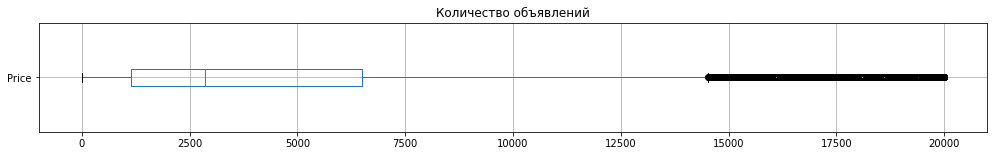

In [42]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data_avto[['Price']].boxplot(vert = False, ax =ax)
ax.set_title('Количество объявлений');

In [43]:
data_avto['Price'].describe()

count   336,318.00
mean      4,529.31
std       4,536.16
min           0.00
25%       1,150.00
50%       2,850.00
75%       6,500.00
max      20,000.00
Name: Price, dtype: float64

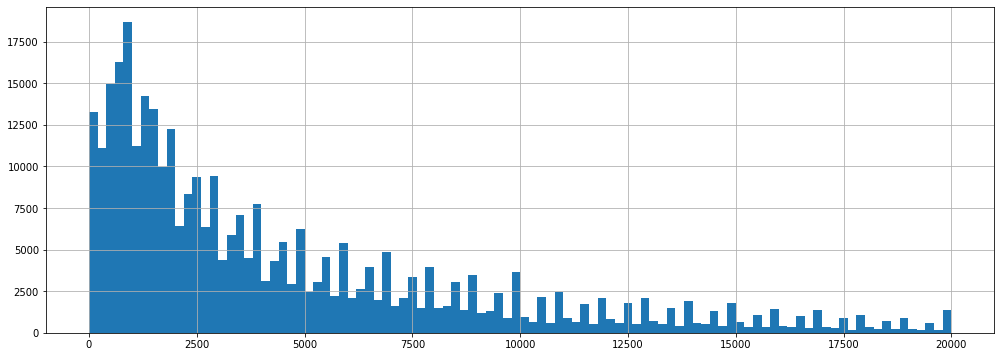

In [44]:
data_avto['Price'].hist(bins=100, figsize=(17,6));

In [45]:
data_avto.query('Price < 50 and NotRepaired == "yes"').count() #меньше 50 у.е. с ремонтом

Price               2066
VehicleType         2066
RegistrationYear    2066
Gearbox             2066
Power               2066
Model               2066
Kilometer           2066
FuelType            2066
Brand               2066
NotRepaired         2066
dtype: int64

In [46]:
data_avto.query('Price < 50').count()

Price               9229
VehicleType         9229
RegistrationYear    9229
Gearbox             9229
Power               9229
Model               9229
Kilometer           9229
FuelType            9229
Brand               9229
NotRepaired         9229
dtype: int64

- Средняя цена на автомобили 4461,72 у.е., медиана - 2799 у.е., максимальная цена 20000 у.е. 
- Количество наблюдений, где цена меньше 50 у.е. 11389, и только 2185 из них были после ремонта.
- Мы удалим все объявления с ценой меньше 50 у.е., так как такие автомобиль скорее всего имеют существенные недостатки (нет документов, существенные аварии, отсутствие главных узлов и т.д.). Всех этих дополнительных данных у нас нет и модель не сможет их учесть.

In [47]:
data_good = data_avto.query('Price >= 50').reset_index(drop=True)
data_good.shape

(327089, 10)

In [48]:
data_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327089 entries, 0 to 327088
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             327089 non-null  int64  
 1   VehicleType       327089 non-null  object 
 2   RegistrationYear  327089 non-null  int64  
 3   Gearbox           327089 non-null  object 
 4   Power             327089 non-null  float64
 5   Model             327089 non-null  object 
 6   Kilometer         327089 non-null  int64  
 7   FuelType          327089 non-null  object 
 8   Brand             327089 non-null  object 
 9   NotRepaired       327089 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 25.0+ MB


In [49]:
data_good.isna().sum().sum() #проверяем

0

### Подготовка данных к обучению

Прямое кодирование:

In [50]:
data_ohe = pd.get_dummies(data_good, drop_first=True) #drop_first чтобы избежать дамми-ловушку

Порядковое кодирование:

In [51]:
encoder = OrdinalEncoder() 

data_good[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.fit_transform(
    data_good[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])

In [52]:
data_good

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4.00,1993,1.00,90.00,116.00,150000,6.00,38.00,0.00
1,18300,2.00,2011,1.00,190.00,29.00,125000,2.00,1.00,1.00
2,9800,6.00,2004,0.00,163.00,117.00,125000,2.00,14.00,0.00
3,1500,5.00,2001,1.00,75.00,116.00,150000,6.00,38.00,0.00
4,3600,5.00,2008,1.00,69.00,101.00,90000,2.00,31.00,0.00
...,...,...,...,...,...,...,...,...,...,...
327084,3200,4.00,2004,1.00,225.00,140.00,150000,6.00,30.00,1.00
327085,1150,0.00,2000,1.00,120.00,249.00,150000,6.00,24.00,0.00
327086,1199,1.00,2000,0.00,101.00,106.00,125000,6.00,32.00,0.00
327087,9200,0.00,1996,1.00,102.00,223.00,150000,2.00,38.00,0.00


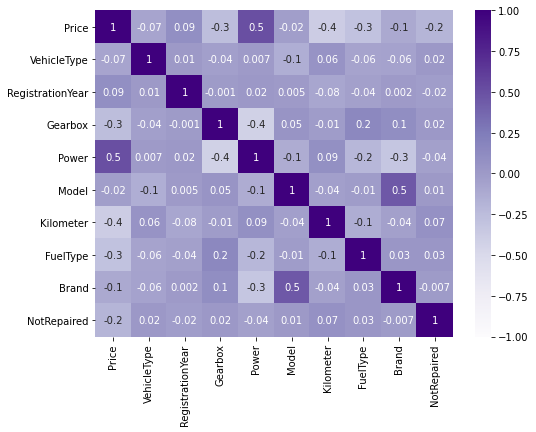

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_good.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'Purples', fmt='.1g');

На графике корреляции видно, что на цену авто сильное влияние оказывает только мощность двигателя.

Делим данные 1/4, на обучающую и тестовую, так как планируем использовать кросс-валидацию при обучении. Так же подготовим два набора обучающих выборок подготовленных прямым и порядковым кодированием:

In [54]:
features_oe = data_good.drop(['Price'], axis=1)
target_oe = data_good['Price']
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.25, random_state=121212)

print(features_train_oe.shape, features_test_oe.shape, target_train_oe.shape, target_test_oe.shape)

(245316, 9) (81773, 9) (245316,) (81773,)


In [55]:
features_ohe = data_ohe.drop(['Price'], axis=1)
target_ohe = data_ohe['Price']
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=121212)

print(features_train_ohe.shape, features_test_ohe.shape, target_train_ohe.shape, target_test_ohe.shape)

(245316, 309) (81773, 309) (245316,) (81773,)


Приведем признаки к одному масштабу. Для этого будем использовать структуру для стандартизации данных StandardScaler.

In [56]:
scaler = StandardScaler()
scaler.fit(features_train_oe)
scaler_features_train_oe = scaler.transform(features_train_oe) # первый набор данных
scaler_features_test_oe = scaler.transform(features_test_oe)


In [57]:
scaler = StandardScaler()
scaler.fit(features_train_ohe)
scaler_features_train_ohe = scaler.transform(features_train_ohe) # второй набор данных
scaler_features_test_ohe = scaler.transform(features_test_ohe)

**Вывод:**
- нам предоставлена выгрузка из базу объявлений о продаже автомобилей, она содержит 354369 наблюдений и 16 признаков (в т.ч. целевой признак - цена)
- в данных содержаться пропуски в VehicleType (кузов), Gearbox (коробка передач), Model (модель автомобиля), FuelType (вид топлива), NotRepaired (ремонт)
- имелись дубликаты, которые были удалены
- были удалены признаки, которые не являются ценообразующими ('NumberOfPictures' - количество фото, 'LastSeen' - дата последней активности пользователя, 'DateCreated' - дата создания анкеты, 'RegistrationMonth' - месяц регистрации авто, 'DateCrawled' - дата скачивания анкеты из базы)
- определены возрастные диапазоны автомобилей - не старше 1970 года выпуска
- проведена работа по исправлению неточностей указания мощности автомобиля (меньше 40 и больше 1000 л/с), заменена часть нулевых значений на медиану по модели/бренду/коробке передач. Часть данных, не подлежащих восстановлению, была удалена. 
- восстановлены пропуски: модель авто, ремонт, коробка передач, вид топлива и тип кузова
- проверен целевой признак: удалены автомобили дешевле 50 у.е.
- удалено 7,7% первоначальных данных

**Данные готовы для дальнейшей работы**
- признаки закодированы и разделены на обучающие и тестовые выборки

## Обучение моделей

Мы планируем использовать следующие модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- Ridge
- ExtraTreesRegressor
- LassoCV
- ElasticNetCV

Напишим функцию для расчета RMSE

In [61]:
def ml(model, features, target):
    scores  = cross_val_score(model, features, target, scoring=make_scorer(mean_squared_error, greater_is_better=False),
                              cv=5,n_jobs=-1)
    mse = np.mean(scores)
    rmse = (mse*-1)**0.5
    return rmse

### Линейная регрессия

Для выборки Ohe

In [63]:
%%time
model = LinearRegression()
rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
print(rmse)

3352.540753051724
CPU times: user 1min 12s, sys: 39.7 s, total: 1min 52s
Wall time: 1min 53s


Для выборки OrdinalEncoder

In [62]:
%%time
model = LinearRegression()
rmse = ml(model, scaler_features_train_oe, target_train_oe)
print(rmse)

3120.1326494826744
CPU times: user 487 ms, sys: 485 ms, total: 972 ms
Wall time: 940 ms


### Случайные лес

Для выборки Ohe (без подборки гиперпараметров, чтобы оченить время работы)

In [67]:
%%time
model = RandomForestRegressor(random_state=0, n_estimators=10, max_depth=10)
rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
print(rmse)

1898.4397971495894
CPU times: user 3min 40s, sys: 1.6 s, total: 3min 41s
Wall time: 3min 43s


Результаты хорошие, но время обработки данного файла очень большое. Подбирать гиперпараметры на данную модель на этой выборке мы не будем (3.5 минут на один цикл с небольшими параметрами).

Для выборки OrdinalEncoder

In [68]:
%%time
model = RandomForestRegressor(random_state=0, n_estimators=10, max_depth=10)
rmse = ml(model, scaler_features_train_oe, target_train_oe)
print(rmse)

1888.8992788472012
CPU times: user 12.8 s, sys: 48 ms, total: 12.9 s
Wall time: 12.9 s


In [61]:
%%time
best_result = 1000000 
est_result = 0 
depth_result = 0

for est in [5, 50, 100]: 
    for depth in range(8, 15):
        model = RandomForestRegressor(random_state=0, n_estimators=est, max_depth=depth)
        rmse = ml(model, scaler_features_train_oe, target_train_oe)
        
        if best_result > rmse:
            best_result = rmse
            est_result = est
            depth_result = depth
            
print(f'Лучший результат rmse {best_result: ,.2f} у модели max_depth = {depth_result},  n_estimators= {est_result}')

Лучший результат rmse  1,666.92 у модели max_depth = 14,  n_estimators= 100
CPU times: user 22min 24s, sys: 2.68 s, total: 22min 27s
Wall time: 22min 28s


### LGBMRegressor

Для выборки Ohe 

In [65]:
%%time
model = LGBMRegressor(random_state=0, n_estimators=25, max_depth=15, boosting_type='dart')
rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
print(rmse)

2659.4261441886583
CPU times: user 45.9 s, sys: 3.05 s, total: 48.9 s
Wall time: 49 s


In [68]:
%%time

bo_ty_list = ['goss'] # были проверены ['gbdt', 'dart', 'goss']

for value in bo_ty_list:
    best_result = 1000000 
    est_result = 0 
    depth_result = 0
    
    for est in [50, 100]:
        for depth in [25]:
            model = LGBMRegressor(boosting_type = value, random_state=0, n_estimators=est, max_depth=depth)
            rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
        
            if best_result > rmse:
                best_result = rmse
                est_result = est
                depth_result = depth
    print(f'Лучший  rmse {best_result: ,.2f}')
    print(f'у модели boosting_type = {value}, max_depth = {depth_result},  n_estimators= {est_result}')

Лучший  rmse  1,700.49
у модели boosting_type = goss, max_depth = 25,  n_estimators= 100
CPU times: user 2min 32s, sys: 5.58 s, total: 2min 38s
Wall time: 2min 39s


Для выборки OrdinalEncoder

In [69]:
%%time
model = LGBMRegressor(random_state=0, n_estimators=25, max_depth=15, boosting_type='dart')
rmse = ml(model, scaler_features_train_oe, target_train_oe)
print(rmse)

2667.171858653596
CPU times: user 11.2 s, sys: 31.9 ms, total: 11.2 s
Wall time: 11.2 s


In [78]:
%%time

bo_ty_list = ['goss'] # были проверены ['gbdt', 'dart', 'goss']

for value in bo_ty_list:
    
    best_result = 1000000 
    est_result = 0 
    depth_result = 0
    
    for est in [100, 110, 120, 130]:
        for depth in range(18, 21):
            model = LGBMRegressor(boosting_type = value, random_state=0, n_estimators=est, max_depth=depth)
            rmse = ml(model, scaler_features_train_oe, target_train_oe)
        
            if best_result > rmse:
                best_result = rmse
                est_result = est
                depth_result = depth
    print(f'Лучший  rmse {best_result: ,.2f}')
    print(f'у модели boosting_type = {value}, max_depth = {depth_result},  n_estimators= {est_result}')

Лучший  rmse  1,680.83
у модели boosting_type = goss, max_depth = 18,  n_estimators= 130
CPU times: user 9min 48s, sys: 2.53 s, total: 9min 51s
Wall time: 9min 56s


### CatBoostRegressor

Для выборки Ohe

In [79]:
for depth in [15, 16]:
    print(f'depth = {depth}')
    params = {"iterations": 100, "depth": depth, "loss_function": "RMSE", "verbose": 1}
    cv_dataset = Pool(data=scaler_features_train_ohe, label=target_train_ohe)
    scores = cv(cv_dataset, params, fold_count=2)

depth = 15
Training on fold [0/2]
0:	learn: 6325.2298354	test: 6346.1511597	best: 6346.1511597 (0)	total: 738ms	remaining: 1m 13s
1:	learn: 6165.4521781	test: 6185.9319981	best: 6185.9319981 (1)	total: 774ms	remaining: 37.9s
2:	learn: 6008.2007181	test: 6028.8361520	best: 6028.8361520 (2)	total: 1.35s	remaining: 43.8s
3:	learn: 5858.4329294	test: 5879.4687545	best: 5879.4687545 (3)	total: 1.98s	remaining: 47.6s
4:	learn: 5710.4431775	test: 5731.7317308	best: 5731.7317308 (4)	total: 2.53s	remaining: 48s
5:	learn: 5568.3122297	test: 5589.6899763	best: 5589.6899763 (5)	total: 3.06s	remaining: 48s
6:	learn: 5432.0436194	test: 5454.0880677	best: 5454.0880677 (6)	total: 3.61s	remaining: 48s
7:	learn: 5300.7409728	test: 5323.2917283	best: 5323.2917283 (7)	total: 4.18s	remaining: 48.1s
8:	learn: 5172.3607080	test: 5194.9097065	best: 5194.9097065 (8)	total: 4.72s	remaining: 47.7s
9:	learn: 5048.0244676	test: 5071.0805558	best: 5071.0805558 (9)	total: 5.26s	remaining: 47.4s
10:	learn: 4929.17478

Лучший результат RMSE = 1815.67 показала модель depth = 16, iterations = 200

Для выборки OrdinalEncoder

In [71]:
for depth in range(15, 17):
    print(f'depth = {depth}')
    params = {"iterations": 200, "depth": depth, "loss_function": "RMSE", "verbose": 1}
    cv_dataset = Pool(data=scaler_features_train_oe, label=target_train_oe)
    scores = cv(cv_dataset, params, fold_count=2)

depth = 15
Training on fold [0/2]


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 6324.6036393	test: 6345.4791684	best: 6345.4791684 (0)	total: 521ms	remaining: 1m 43s
1:	learn: 6164.0809084	test: 6185.5176358	best: 6185.5176358 (1)	total: 1.07s	remaining: 1m 46s
2:	learn: 6009.8048532	test: 6031.8742427	best: 6031.8742427 (2)	total: 1.63s	remaining: 1m 46s
3:	learn: 5859.9765739	test: 5882.1355750	best: 5882.1355750 (3)	total: 1.92s	remaining: 1m 33s
4:	learn: 5714.6355087	test: 5737.6668722	best: 5737.6668722 (4)	total: 2.48s	remaining: 1m 36s
5:	learn: 5572.0106254	test: 5595.4881690	best: 5595.4881690 (5)	total: 3.02s	remaining: 1m 37s
6:	learn: 5436.7804264	test: 5460.9054095	best: 5460.9054095 (6)	total: 3.59s	remaining: 1m 39s
7:	learn: 5307.3046104	test: 5332.4914053	best: 5332.4914053 (7)	total: 4.21s	remaining: 1m 40s
8:	learn: 5177.8958335	test: 5203.5641954	best: 5203.5641954 (8)	total: 4.73s	remaining: 1m 40s
9:	learn: 5051.9593458	test: 5078.0804625	best: 5078.0804625 (9)	total: 5.26s	remaining: 1m 39s
10:	learn: 4931.3681342	test: 4957.98306

Лучший результат RMSE = 1676.49 показала модель depth = 16, iterations = 200

### Ridge

Для выборки Ohe

In [79]:
%%time
for value in [0.1, 0.3, 1, 4]:
    print(f'alpha = {value}')
    model = Ridge(alpha = value)
    rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
    print(f'rmse = {rmse: ,.2f}')

alpha = 0.1
rmse =  2,832.13
alpha = 0.3
rmse =  2,832.13
alpha = 1
rmse =  2,832.13
alpha = 4
rmse =  2,832.13
CPU times: user 34.6 s, sys: 18.8 s, total: 53.4 s
Wall time: 53.7 s


Для выборки OrdinalEncoder

In [81]:
%%time
for value in [0.1, 1, 4, 15]:
    print(f'alpha = {value}')
    model = Ridge(alpha = value)
    rmse = ml(model, scaler_features_train_oe, target_train_oe)
    print(f'rmse = {rmse: ,.2f}')

alpha = 0.1
rmse =  3,113.15
alpha = 1
rmse =  3,113.15
alpha = 4
rmse =  3,113.15
alpha = 15
rmse =  3,113.15
CPU times: user 1.5 s, sys: 2.32 s, total: 3.82 s
Wall time: 3.77 s


### ExtraTreesRegressor

Для выборки Ohe

In [60]:
%%time
model = ExtraTreesRegressor(n_estimators = 25, random_state=0)
rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
print(f'rmse = {rmse: ,.2f}')

rmse =  1,639.36
CPU times: user 17min 24s, sys: 4.35 s, total: 17min 28s
Wall time: 17min 31s


Для выборки OrdinalEncoder

In [62]:
%%time
for est in [75, 120, 150]:
    print(f'n_estimators = {est}')
    model = ExtraTreesRegressor(n_estimators = est, random_state=0)
    rmse = ml(model, scaler_features_train_oe, target_train_oe)
    print(f'rmse = {rmse: ,.2f}')


n_estimators = 75
rmse =  1,653.21
n_estimators = 120
rmse =  1,651.06
n_estimators = 150
rmse =  1,650.10
CPU times: user 9min 39s, sys: 12.8 s, total: 9min 51s
Wall time: 9min 53s


### Lasso

Для выборки Ohe

In [63]:
%%time
for value in [1]:
    print(f'alpha = {value}')
    model = Lasso(alpha = value)
    rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
    print(f'rmse = {rmse: ,.2f}')

alpha = 1
rmse =  2,832.60
CPU times: user 10min, sys: 11min 49s, total: 21min 49s
Wall time: 21min 52s


Для выборки OrdinalEncoder

In [85]:
%%time
for value in [0.1, 1, 4, 0.7]:
    print(f'alpha = {value}')
    model = Lasso(alpha = value)
    rmse = ml(model, scaler_features_train_oe, target_train_oe)
    print(f'rmse = {rmse: ,.2f}')

alpha = 0.1
rmse =  3,113.15
alpha = 1
rmse =  3,113.14
alpha = 4
rmse =  3,113.16
alpha = 0.7
rmse =  3,113.15
CPU times: user 2.46 s, sys: 3.33 s, total: 5.78 s
Wall time: 5.8 s


### ElasticNetCV

Для выборки Ohe

In [64]:
%%time
for value in [1]:
    model = ElasticNetCV(l1_ratio = value)
    rmse = ml(model, scaler_features_train_ohe, target_train_ohe)
    print(f'rmse = {rmse: ,.2f}')

rmse =  2,833.14
CPU times: user 7min 6s, sys: 4min 45s, total: 11min 51s
Wall time: 11min 57s


Для выборки OrdinalEncoder

In [71]:
%%time
for value in [0.3, 1, 0.7]: 
    print(f'l1_ratio = {value}')
    model = ElasticNetCV(l1_ratio = value)
    rmse = ml(model, scaler_features_train_oe, target_train_oe)
    print(f'rmse = {rmse: ,.2f}')

l1_ratio = 0.3
rmse =  4,143.19
l1_ratio = 1
rmse =  3,113.16
l1_ratio = 0.7
rmse =  3,508.94
CPU times: user 23.7 s, sys: 29.2 s, total: 52.9 s
Wall time: 53.4 s


**Выводы:**
1. Для выборки Ohe
    - модель LinearRegression: rmse - 5542.57
    - модель RandomForestRegressor: rmse - 1898.44, время на один цикл 3.5 минуты в связи с чем подбор гиперпараметров не осуществлялся;
    - модель LGBMRegressor: rmse - 1700,49 (boosting_type = goss, n_estimators=100, max_depth=25)
    - модель CatBoostRegressor (Pool): rmse - 1815.67 (iterations": 200, depth = 16)
    - модель Ridge: rmse - 2832,13 (гиперпараметр alpha влияние не оказывает)
    - модель *ExtraTreesRegressor: rmse - 1639.36* (n_estimators = 25), время на один цикл 17.5 минут в связи с чем подбор гиперпараметров не осуществлялся;
    - модель Lasso: rmse - 2832.60, время на один цикл 22 минуты в связи с чем подбор гиперпараметров не осуществлялся;
    - модель ElasticNetCV: rmse - 2833.14, время на один цикл 12 минут в связи с чем подбор гиперпараметров не осуществлялся
    
2. Для выборки OrdinalEncoder
    - модель LinearRegression: rmse - 3113.15
    - модель *RandomForestRegressor: rmse - 1666,92* (max_depth = 14,  n_estimators= 100)
    - модель LGBMRegressor: rmse - 1680.83 (boosting_type = goss, n_estimators=130, max_depth=18)
    - модель *CatBoostRegressor (Pool): rmse - 1676.49* (iterations": 200, depth = 16)
    - модель Ridge: rmse - 3113,15 (гиперпараметр alpha влияние не оказывает)
    - модель *ExtraTreesRegressor: rmse - 1650,10* (n_estimators = 150)
    - модель Lasso: rmse - 3113,14 (гиперпараметр alpha влияние оказывает крайне слабо)
    - модель ElasticNetCV: rmse - 3113.16 (l1_ratio = 1)

## Анализ моделей

Тестировать и сравнивать мы будем только те модели, результаты которых уложились в условия задачи (ТОП-4):
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- ExtraTreesRegressor

Модель ExtraTreesRegressor на выборке Ohe показала хороший результат rmse - 1639.36 (n_estimators = 25), однако время на один цикл 17.5 минут. Данная модель не будет протестирована на тестовой выборке, так как одним из главных условий ТЗ - скорость работы.

In [61]:
def ml_predict(model, x_features, x_target, y_features, y_target):
    model.fit(x_features, x_target)
    predict = model.predict(y_features)
    rmse = mean_squared_error(predict, y_target)**0.5
    return rmse

In [60]:
print(scaler_features_train_oe.shape, target_train_oe.shape, scaler_features_test_oe.shape, target_test_oe.shape) 
# предпроверка данных перед работой (именно сейчас нашла ошибку, так что пусть будет)

(245313, 9) (245313,) (81772, 9) (81772,)


In [61]:
%%time
model = RandomForestRegressor(random_state=121314, n_estimators=100, max_depth=14)
rmse = ml_predict(model, scaler_features_train_oe, target_train_oe, scaler_features_test_oe, target_test_oe)
print(F'rmse = {rmse: ,.2f}')

rmse =  1,656.08
CPU times: user 37.7 s, sys: 189 ms, total: 37.9 s
Wall time: 37.9 s


In [62]:
cat = CatBoostRegressor()
cat.fit(scaler_features_test_oe, target_test_oe, verbose=False, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
%%time
model = LGBMRegressor(random_state=121314, boosting_type = 'goss', n_estimators=130, max_depth=18)
rmse = ml_predict(model, scaler_features_train_oe, target_train_oe, scaler_features_test_oe, target_test_oe)
print(F'rmse = {rmse: ,.2f}')

rmse =  1,672.84
CPU times: user 59.9 s, sys: 373 ms, total: 1min
Wall time: 1min


In [64]:
%%time
model = ExtraTreesRegressor(n_estimators = 150, random_state=121314)
rmse = ml_predict(model, scaler_features_train_oe, target_train_oe, scaler_features_test_oe, target_test_oe)
print(F'rmse = {rmse: ,.2f}')

rmse =  1,636.43
CPU times: user 1min 5s, sys: 1.5 s, total: 1min 6s
Wall time: 1min 7s


Эталонная модель для сравнения результатов:

In [63]:
%%time
model = DummyRegressor()
rmse = ml_predict(model, scaler_features_train_oe, target_train_oe, scaler_features_test_oe, target_test_oe)
print(F'rmse = {rmse: ,.2f}')

rmse =  4,528.89
CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 2.28 ms


**Вывод**
- Лидер по качеству и скорости работы модель CatBoostRegressor, время всего 3 секунды
- модель ExtraTreesRegressor с результатом 1,636.43 справилась за 1,1 минуту
- модель RandomForestRegressor с результатом rmse =  1,656.08, справилась за 39,5 секунд
- модель LGBMRegressor с результатом rmse =  1672,84, справилась за 1 минуту
- эталонная модель показала результат rmse =  4528.89, уложившись в 2.28 секунд 

## Вывод

1. нам предоставлена выгрузка из базу объявлений о продаже автомобилей, она содержит 354369 наблюдений и 16 признаков (в т.ч. целевой признак - цена)
- в данных содержаться пропуски в VehicleType (кузов), Gearbox (коробка передач), Model (модель автомобиля), FuelType (вид топлива), NotRepaired (ремонт)
- имелись дубликаты, которые были удалены
- были удалены признаки, которые не являются ценообразующими ('NumberOfPictures' - количество фото, 'LastSeen' - дата последней активности пользователя, 'DateCreated' - дата создания анкеты, 'RegistrationMonth' - месяц регистрации авто, 'DateCrawled' - дата скачивания анкеты из базы)
- определены возрастные диапазоны автомобилей - не старше 1970 года выпуска
- проведена работа по исправлению неточностей указания мощности автомобиля (меньше 40 и больше 1000 л/с), заменена часть нулевых значений на медиану по модели/бренду/коробке передач. Часть данных, не подлежащих восстановлению, была удалена.
- восстановлены пропуски: модель авто, ремонт, коробка передач, вид топлива и тип кузова
- проверен целевой признак: удалены автомобили дешевле 50 у.е.
- удалено 7,7% первоначальных данных

При проверки моделей кросс-валидацией на обучающих выборках были получены следующие результаты:

2. Для выборки Ohe
    - модель LinearRegression: rmse - 5542.57
    - модель RandomForestRegressor: rmse - 1898.44, время на один цикл 3.5 минуты в связи с чем подбор гиперпараметров не осуществлялся;
    - модель LGBMRegressor: rmse - 1700,49 (boosting_type = goss, n_estimators=100, max_depth=25)
    - модель CatBoostRegressor (Pool): rmse - 1815.67 (iterations": 200, depth = 16)
    - модель Ridge: rmse - 2832,13 (гиперпараметр alpha влияние не оказывает)
    - модель *ExtraTreesRegressor: rmse - 1639.36* (n_estimators = 25), время на один цикл 17.5 минут в связи с чем подбор гиперпараметров не осуществлялся;
    - модель Lasso: rmse - 2832.60, время на один цикл 22 минуты в связи с чем подбор гиперпараметров не осуществлялся;
    - модель ElasticNetCV: rmse - 2833.14, время на один цикл 12 минут в связи с чем подбор гиперпараметров не осуществлялся
    
3. Для выборки OrdinalEncoder
    - модель LinearRegression: rmse - 3113.15
    - модель *RandomForestRegressor: rmse - 1666,92* (max_depth = 14,  n_estimators= 100)
    - модель LGBMRegressor: rmse - 1680.83 (boosting_type = goss, n_estimators=130, max_depth=18)
    - модель *CatBoostRegressor (Pool): rmse - 1676.49* (iterations": 200, depth = 16)
    - модель Ridge: rmse - 3113,15 (гиперпараметр alpha влияние не оказывает)
    - модель *ExtraTreesRegressor: rmse - 1650,10* (n_estimators = 150)
    - модель Lasso: rmse - 3113,14 (гиперпараметр alpha влияние оказывает крайне слабо)
    - модель ElasticNetCV: rmse - 3113.16 (l1_ratio = 1)

Для проверки на тестовой выборке мы отобрали следующие модели, результаты которых уложились в условия задачи (ТОП-4):

- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor
- ExtraTreesRegressor

4. На тестовой выборке все модели уложились в заданные параметры качества:
- **Лидер по качеству и скорости работы модель CatBoostRegressor, время всего 3 секунды**
- модель ExtraTreesRegressor с результатом 1,636.43 справилась за 1,1 минуту
- модель RandomForestRegressor с результатом rmse =  1,656.08, справилась за 39,5 секунд
- модель LGBMRegressor с результатом rmse =  1672,84, справилась за 7,7 минут
- эталонная модель показала результат rmse = 4528.89, уложившись в 2.28 секунд 

<div class='alert alert-info'>🏁 Образцовая работа! Качественно исследовала и предобработала признаки, рассмотрела много моделей и 2 способа кодирования, корректно сформировала выборки, сделала перебор гиперпараметров, строила красивые визуализации. 
</div>